# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2019-08-26 20:26:33,011 INFO    : root         : Using LISA logging configuration:
2019-08-26 20:26:33,013 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual

from android import System

import subprocess

from systrace_parser import systrace_parser

2019-08-26 20:26:33,263 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2019-08-26 20:26:33,278 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

## Defines

In [5]:
#file_name = 'G9750/com.eg.android.AlipayGphone_1.html'
file_name = 'com.eg.android.AlipayGphone_3.html'

## Support Functions

###  ---  Trace Mark Functions

###  ---  Sched Functions

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
}

In [7]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            new_one = True
            for file_group in file_groups:
                length_of_file = len(filename)
                if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                    #print('before  {}'.format(file_groups))
                    file_groups.remove(file_group)
                    file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)
    file_groups.sort()
    for file_group in file_groups:
        descript = '{}{}'.format(dirname, file_group)
        #print('{}{}'.format(dirname, file_group))
        chboxes.append(widgets.Checkbox(
                value=False,
                description=descript.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnQ2FsbG9nL0EyMDdGU0g5X1BPU18xOTA4MjJfMTkwODIyXzEwNDgxN19jYWxsbG8/Lmh0bWwnLCBsYXnigKY=


In [66]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        length_of_file = len(file_path[-1])
        new_file_path += file_path[-1][:length_of_file/2] + '*.html'
        #print(new_file_path)
        filelist.append(glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path))
        filelist[-1].sort()
        title += [new_file_path]
#filelist

## Reading Files

In [67]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [68]:
group1.run()
group2.run()

Parsing 379575 lines are Ok
Parsing 290074 lines are Ok
Parsing 290439 lines are Ok
Parsing 274218 lines are Ok
Parsing 270095 lines are Ok
Parsing 198786 lines are Ok
Parsing 316855 lines are Ok
Parsing 299132 lines are Ok
Parsing 301678 lines are Ok
Parsing 270280 lines are Ok


## Analysis

### The timing of marking data

In [69]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

Nytimes/A207F_Nytimes_2019_0*.html


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
15889.0,NaN,NaN,49.701,NaN,16.271,NaN,NaN
15977.0,NaN,NaN,721284.180,NaN,12.017,NaN,NaN
1967.0,3.433,0.130,NaN,NaN,NaN,NaN,NaN
1368.0,1.467,0.004,NaN,NaN,NaN,NaN,2148.58
15989.0,NaN,NaN,63.231,NaN,10.741,NaN,NaN
2569.0,2.426,0.052,NaN,NaN,NaN,NaN,NaN
3128.0,3.635,12.719,NaN,NaN,NaN,NaN,NaN
15709.0,429.753,69.079,618.220,680.134,14.215,320.956,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
16728.0,NaN,NaN,744807.077,NaN,23.548,NaN,NaN
16486.0,NaN,NaN,739081.923,NaN,13.532,NaN,NaN
16521.0,376.987,66.931,521.452,514.857,31.552,372.746,NaN
1967.0,3.062,0.123,NaN,NaN,NaN,NaN,NaN
1368.0,1.822,1.190,NaN,NaN,NaN,NaN,2012.04
16694.0,NaN,NaN,53.234,NaN,20.933,NaN,NaN
3128.0,2.557,12.128,NaN,NaN,NaN,NaN,NaN
16830.0,NaN,NaN,746107.997,NaN,10.888,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
3128.0,2.565,9.919,NaN,NaN,NaN,NaN,NaN
1368.0,0.017,0.005,NaN,NaN,NaN,NaN,1662.625
16915.0,321.972,58.255,512.581,424.642,12.578,266.68,NaN
17076.0,NaN,NaN,53.838,NaN,12.169,NaN,NaN
1967.0,2.910,0.125,NaN,NaN,NaN,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
3128.0,0.296,10.323,NaN,NaN,NaN,NaN,NaN
1368.0,2.671,1.321,NaN,NaN,NaN,NaN,1740.057
17244.0,341.337,63.117,539.758,420.782,14.315,278.948,NaN
17412.0,NaN,NaN,54.456,NaN,11.666,NaN,NaN
1967.0,3.266,0.124,NaN,NaN,NaN,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
3128.0,2.620,10.415,NaN,NaN,NaN,NaN,NaN
1368.0,1.304,0.020,NaN,NaN,NaN,NaN,1682.56
17759.0,NaN,NaN,49.636,NaN,11.215,NaN,NaN
17595.0,335.409,58.073,521.717,417.99,13.391,276.353,NaN
1967.0,9.921,0.116,NaN,NaN,NaN,NaN,NaN


In [70]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

Nytimes/J810F_Nytimes_2019_0*.html


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
17576.0,10.380,2.575,NaN,NaN,NaN,NaN,NaN
1902.0,1.109,0.082,NaN,NaN,NaN,NaN,NaN
1680.0,5.928,0.031,NaN,NaN,NaN,NaN,NaN
3095.0,0.561,NaN,NaN,NaN,NaN,NaN,NaN
3067.0,2.385,0.133,NaN,NaN,NaN,NaN,NaN
17823.0,NaN,NaN,34.659,NaN,10.463,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
17957.0,309.907,80.423,540.732,431.539,9.429,312.412,NaN
1902.0,3.196,0.159,NaN,NaN,NaN,NaN,NaN
1680.0,1.542,10.380,NaN,NaN,NaN,NaN,NaN
1681.0,0.673,0.509,NaN,NaN,NaN,NaN,NaN
18130.0,NaN,NaN,27.963,NaN,8.590,NaN,NaN
1589.0,NaN,NaN,NaN,NaN,NaN,NaN,2034.003
3095.0,0.332,4.214,NaN,NaN,NaN,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
1902.0,1.710,0.401,NaN,NaN,NaN,NaN,NaN
1680.0,2.996,1.417,NaN,NaN,NaN,NaN,NaN
1681.0,0.593,0.619,NaN,NaN,NaN,NaN,NaN
1589.0,NaN,NaN,NaN,NaN,NaN,NaN,1998.768
3095.0,0.307,1.734,NaN,NaN,NaN,NaN,NaN
18426.0,NaN,NaN,28.147,NaN,10.258,NaN,NaN
18266.0,317.952,79.533,522.816,435.319,10.143,288.673,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
1902.0,3.087,0.163,NaN,NaN,NaN,NaN,NaN
1680.0,3.409,1.358,NaN,NaN,NaN,NaN,NaN
1681.0,0.956,0.540,NaN,NaN,NaN,NaN,NaN
18740.0,NaN,NaN,27.331,NaN,10.237,NaN,NaN
1589.0,NaN,NaN,NaN,NaN,NaN,NaN,2001.173
18582.0,313.043,79.783,535.037,429.343,10.624,287.631,NaN
3095.0,0.276,3.064,NaN,NaN,NaN,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
19072.0,NaN,NaN,29.957,NaN,9.312,NaN,NaN
1902.0,0.118,2.573,NaN,NaN,NaN,NaN,NaN
1680.0,1.344,0.036,NaN,NaN,NaN,NaN,NaN
1681.0,0.685,2.127,NaN,NaN,NaN,NaN,NaN
1589.0,NaN,NaN,NaN,NaN,NaN,NaN,2024.414
3095.0,2.746,3.437,NaN,NaN,NaN,NaN,NaN
18907.0,327.205,78.882,517.063,431.052,13.402,280.221,NaN


### Total Time

In [71]:
list_of_df = group1.get_marking_time()
count = 0
for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        count += 1
        try :
            sum_df += get_launching
        except :
            sum_df = get_launching
        
sum_df.columns.name = group1.title
display(sum_df * 1000 / count)
del(sum_df)

list_of_df = group2.get_marking_time()
count = 0
for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        count += 1
        try :
            sum_df += get_launching
        except :
            sum_df = get_launching
        
sum_df.columns.name = group2.title
display(sum_df * 1000 / count)
del(sum_df)

Nytimes/A207F_Nytimes_2019_0*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
1368.0,1.4562,0.508,NaN,NaN,NaN,NaN,1849.1724


Nytimes/J810F_Nytimes_2019_0*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
1589.0,NaN,NaN,NaN,NaN,NaN,NaN,2014.5895


### Process Time(AVERAGE)

In [53]:
df1 = group1.get(group1.process_state()).dropna(axis=1) * 1000
df1.columns.name = group1.title
display(df1)

df2 = group2.get(group2.process_state()).dropna(axis=1) * 1000
df2.columns.name = group2.title
display(df2)

df3 = df1 - df2
df3.columns.name = 'DIFF'
display(df3)

Naver/A207F_Naver_2019_08*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
time,640.6825,36.6735,575.2555,295.0195,13.4695,48.0415
RUNNING,551.6350,9.5835,463.2730,220.2910,4.1930,22.2260
RUNNABLE,55.6060,0.8680,40.3775,23.9770,1.3705,7.9645
SLEEPING,32.3515,26.2220,34.8600,37.1450,7.9060,17.8425
UNINTERUPTIBLE_SLEEP,0.6125,0.0000,17.1080,13.2815,0.0000,0.0085
UNINTERUPTIBLE_SLEEP(I/O),0.4775,0.0000,19.6370,0.3250,0.0000,0.0000


Naver/J810F_Naver_2019_08*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
time,623.47450,52.44275,547.20900,294.22275,20.26000,35.67825
RUNNING,551.23075,10.13425,454.25600,216.63125,4.44975,20.37100
RUNNABLE,42.23475,0.08125,30.15175,18.39150,2.55575,6.67375
SLEEPING,29.82550,42.22725,56.82600,58.09200,12.92475,8.62850
UNINTERUPTIBLE_SLEEP,0.18350,0.00000,4.00300,0.92775,0.00000,0.00500
UNINTERUPTIBLE_SLEEP(I/O),0.00000,0.00000,1.97225,0.18025,0.32975,0.00000


DIFF,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
time,17.20800,-15.76925,28.04650,0.79675,-6.79050,12.36325
RUNNING,0.40425,-0.55075,9.01700,3.65975,-0.25675,1.85500
RUNNABLE,13.37125,0.78675,10.22575,5.58550,-1.18525,1.29075
SLEEPING,2.52600,-16.00525,-21.96600,-20.94700,-5.01875,9.21400
UNINTERUPTIBLE_SLEEP,0.42900,0.00000,13.10500,12.35375,0.00000,0.00350
UNINTERUPTIBLE_SLEEP(I/O),0.47750,0.00000,17.66475,0.14475,-0.32975,0.00000


In [64]:
dfs = group1.get(group1.process_state(), func='array')

for df in dfs:
    #display(df[:1])
    try:
        df_concat = pd.combine(df[:1], func='fill_value')
    except:
        df_concat = df[:1]
#df_concat = dfs[0][:1].combine(dfs[1][:1])
df_concat.columns.name = group1.title
display(df_concat)

dfs = group2.get(group1.process_state(), func='array')

for df in dfs:
    #display(df[:1])
    try:
        df_concat = pd.combine(df[:1], func='fill_value')
    except:
        df_concat = df[:1]
#df_concat = dfs[0][:1].combine(dfs[1][:1])
df_concat.columns.name = group2.title
display(df_concat)

Naver/A207F_Naver_2019_08*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
time,0.654838,0.037514,0.556876,0.290513,0.011877,0.050155,NaN


Naver/J810F_Naver_2019_08*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
time,0.620675,0.055053,0.548344,0.252734,0.010007,0.036802,NaN


### Uninterruptible Sleep

In [55]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

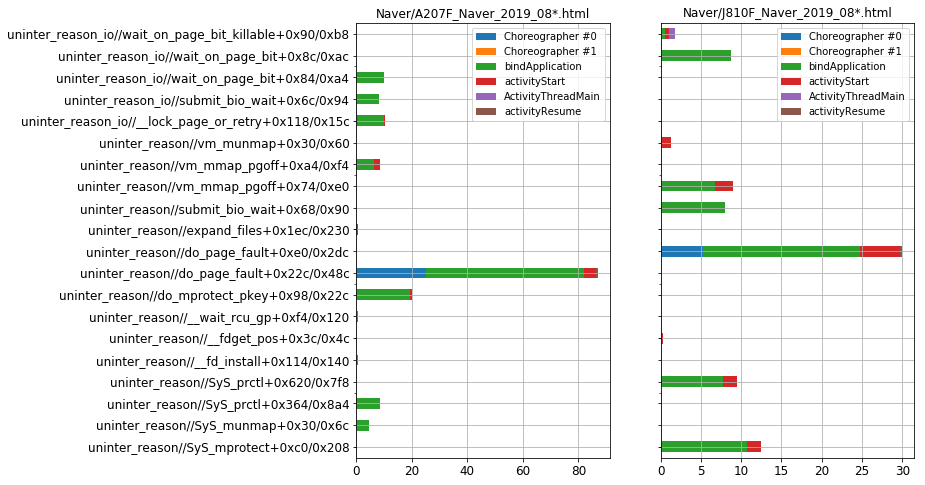

In [56]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

### Number of Running Cores

Naver/A207F_Naver_2019_08*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
core0,6,0,63,1,1,0
core1,37,0,23,3,0,0
core2,2,0,13,0,0,0
core3,30,0,7,0,0,1
core4,249,3,90,89,3,17
core5,192,3,226,78,3,32
core6,83,5,125,35,0,18
core7,99,1,93,23,2,5


Naver/J810F_Naver_2019_08*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
core0,12,1,37,7,2,1
core1,12,0,44,10,0,0
core2,3,0,17,13,0,0
core3,3,0,16,28,0,0
core4,674,5,428,253,6,51
core5,278,16,233,83,1,52
core6,89,0,172,64,3,37
core7,90,5,150,69,1,15


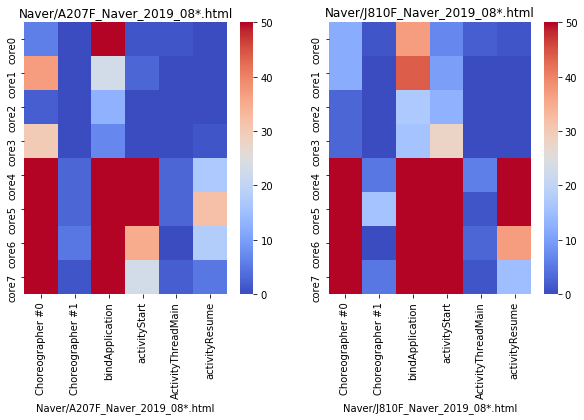

In [57]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
display(df2)

plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [65]:
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,3,1,11,3,1,1,NaN
core1,2,0,8,2,0,0,NaN
core2,0,0,7,0,0,0,NaN
core3,0,0,9,3,0,0,NaN
core4,235,0,116,62,0,25,NaN
core5,45,4,55,28,0,6,NaN
core6,26,0,38,15,0,5,NaN
core7,21,3,55,8,1,1,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,4,0,10,1,1,0,NaN
core1,9,0,12,2,0,0,NaN
core2,2,0,5,0,0,0,NaN
core3,2,0,2,2,0,0,NaN
core4,180,0,90,91,4,13,NaN
core5,49,6,68,12,1,11,NaN
core6,18,0,54,8,0,11,NaN
core7,14,0,41,6,0,4,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,1,0,6,3,0,0,NaN
core1,1,0,12,5,0,0,NaN
core2,0,0,2,11,0,0,NaN
core3,1,0,1,23,0,0,NaN
core4,92,5,124,25,2,0,NaN
core5,102,0,43,32,0,25,NaN
core6,25,0,46,23,1,9,NaN
core7,42,2,31,52,0,8,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,4,0,10,0,0,0,NaN
core1,0,0,12,1,0,0,NaN
core2,1,0,3,2,0,0,NaN
core3,0,0,4,0,0,0,NaN
core4,167,0,98,75,0,13,NaN
core5,82,6,67,11,0,10,NaN
core6,20,0,34,18,2,12,NaN
core7,13,0,23,3,0,2,NaN
